In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [3]:
p_name = "Object_recognition_basics"

# Data setup

In [4]:
PATH = Path('data/pascal')
assert str(PATH) == 'data/pascal'
list(PATH.iterdir())

[PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/tmp')]

### Annotations for the bound boxes

In [5]:
trn_json = json.load((PATH / 'pascal_train2007.json').open())
assert trn_json.keys() is not []
trn_json.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

###### Better to use CONSTANTS as provide better auto-complete and we don't mistype them

In [6]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']

In [7]:
trn_json[IMAGES][:2]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480}]

In [8]:
trn_json[ANNOTATIONS][:1]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]}]

In [9]:
trn_json[CATEGORIES][:2]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'}]

### Let's create some dict of key data

In [10]:
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name','id','image_id','category_id','bbox'

In [11]:
cats = {cat[ID] : cat['name'] for cat in trn_json[CATEGORIES]}

In [12]:
cats

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [13]:
trn_fnames = {img[ID] : img[FILE_NAME] for img in trn_json[IMAGES]}

In [14]:
trn_ids = [img[ID] for img in trn_json[IMAGES]]

In [15]:
trn_ids[:2]

[12, 17]

In [16]:
' '.join(trn_fnames[key] for key in trn_ids[:5])

'000012.jpg 000017.jpg 000023.jpg 000026.jpg 000032.jpg'

In [17]:
JPEGS_PATH = 'VOCdevkit/VOC2007/JPEGImages'

In [18]:
IMG_PATH = PATH / JPEGS_PATH
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/006948.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005796.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007006.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/004693.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/002279.jpg')]

In [19]:
img0_d = trn_json[IMAGES][0]
img0_d[FILE_NAME], img0_d[ID]

('000012.jpg', 12)

A `defaultdict` is useful any time you want to have a default dictionary entry for new keys. Here we create a dict from image IDs to a list of annotations (tuple of bounding box and class id).

#### We convert VOC's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.

In [20]:
trn_json[ANNOTATIONS][0]

{'area': 34104,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0,
 'image_id': 12,
 'iscrowd': 0,
 'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]}

In [21]:
trn_anno = collections.defaultdict(lambda: []) # empty dict
for a in trn_json[ANNOTATIONS]:
    if not a['ignore']:
        bb = a[BBOX]
        bb = np.array([bb[1], bb[0], bb[3] + bb[1] - 1, bb[2] + bb[0] - 1])
        trn_anno[a[IMG_ID]].append( (bb, a[CAT_ID]) )

In [22]:
trn_anno[img0_d[ID]]

[(array([ 96, 155, 269, 350]), 7)]

In [23]:
cats[7]

'car'

In [24]:
def bb_2_hw(hw):
    """
    Some libs take VOC format bounding boxes, so this let's us convert back when required:
    """
    return np.array([hw[1], hw[0], hw[3] - hw[1], hw[2] - hw[0]])
    

In [25]:
def show_img(img, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
        
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    return ax

In [26]:
def draw_outline(shape, line_w):
    shape.set_path_effects( [patheffects.Stroke(linewidth=line_w, 
                                              foreground='black'), patheffects.Normal()] )

###### Note that `*` in argument lists is the [splat operator](https://stackoverflow.com/questions/5239856/foggy-on-asterisk-in-python). In this case it's a little shortcut compared to writing out `b[-2],b[-1]`.

In [27]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [28]:
def draw_txt(ax, pos, txt, sz=14):
    text = ax.text(*pos, txt, verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [29]:
img0_d[ID]

12

In [30]:
a_img = trn_anno[img0_d[ID]][0]; a_img

(array([ 96, 155, 269, 350]), 7)

In [31]:
im = open_image(IMG_PATH / img0_d[FILE_NAME])

[ 96 155 269 350]
[155  96 195 173]
7
car


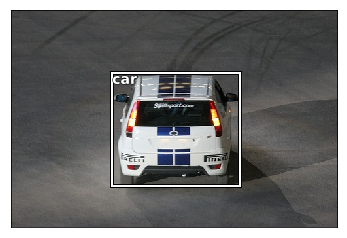

In [32]:
ax = show_img(im)
b = bb_2_hw(a_img[0])
print(a_img[0])
print(b)
print(a_img[1])
print(cats[a_img[1]])
draw_rect(ax, b)
draw_txt(ax, b[:2], cats[a_img[1]])

In [33]:
def draw_im(img, anno):
    ax = show_img(img, figsize=(16, 8))
    for box, cat_id in anno: # render all bounding boxes
        b = bb_2_hw(box)
        draw_rect(ax, b)
        draw_txt(ax, b[:2], cats[cat_id], sz=16 )

In [34]:
def draw_anno_idx(a_idx):
    img_anno = trn_anno[a_idx]
    img = open_image(IMG_PATH / trn_fnames[a_idx])
    print(img.shape)
    draw_im(img, img_anno)

(364, 480, 3)


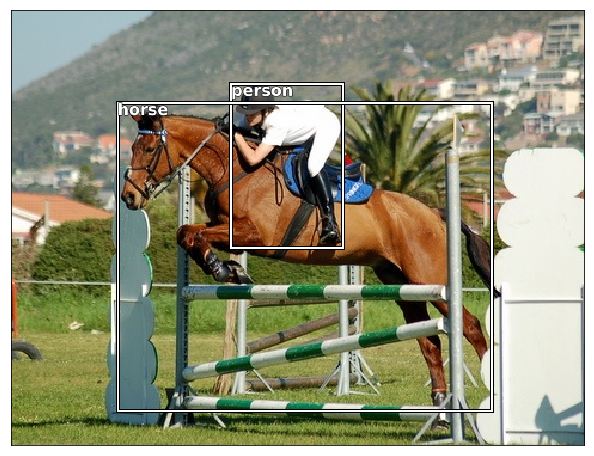

In [35]:
draw_anno_idx(17)

#### Get the larget bounding box for each annotation

In [36]:
trn_anno[23]

[(array([229,   8, 499, 244]), 2),
 (array([219, 229, 499, 333]), 2),
 (array([  0,   1, 368, 116]), 15),
 (array([  1,   2, 461, 242]), 15),
 (array([  0, 224, 485, 333]), 15)]

In [37]:
def get_lrg(b):
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [38]:
trn_lrg_anno = {id: get_lrg(bb) for id, bb in trn_anno.items()}
bb, cat = trn_lrg_anno[23]
bb = bb_2_hw(bb)

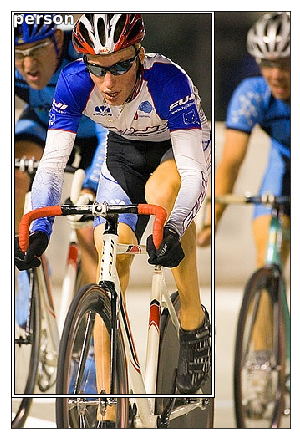

In [39]:
ax = show_img(open_image(IMG_PATH / trn_fnames[23]), figsize=(5, 10))
draw_rect(ax, bb)
draw_txt(ax, bb[:2], cats[cat], sz=16)

#### Often it's easiest to simply create a CSV of the data you want to model, rather than trying to create a custom dataset. Here we use Pandas to help us create a CSV of the image filename and class.

In [40]:
(PATH / 'tmp').mkdir(exist_ok=True)

In [41]:
LRG_BB_CSV = PATH / 'tmp/largest_bb.csv'

In [42]:
df = pd.DataFrame({'fn': [trn_fnames[i] for i in trn_ids], 
                'cat' : [cats[trn_lrg_anno[i][1]] for i in trn_ids]}, 
               columns=['fn', 'cat'] )

In [43]:
df.head()

,fn,cat
0,000012.jpg,car
1,000017.jpg,horse
2,000023.jpg,person
3,000026.jpg,car
4,000032.jpg,aeroplane


In [44]:
df.to_csv(LRG_BB_CSV, index=False)

# Model - similar to cats Vs dogs

In [45]:
f_model = resnet34
sz = 224
bs = 64

In [46]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
model_data = ImageClassifierData.from_csv(PATH, JPEGS_PATH, LRG_BB_CSV, tfms=tfms)

In [47]:
x, y = next(iter(model_data.trn_dl))

In [48]:
x.shape

torch.Size([64, 3, 224, 224])

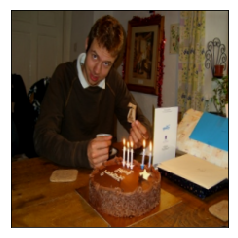

In [49]:
show_img(model_data.val_ds.denorm(to_np(x))[0])

In [50]:
learn = ConvLearner.pretrained(f_model, model_data, metrics=[accuracy])
learn.opt_fn = optim.Adam

In [51]:
lr_f = learn.lr_find(1e-5, 100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 25/32 [00:08<00:02,  2.82it/s, loss=12.2]


#### When you LR finder graph looks like this, you can ask for more points on each end:

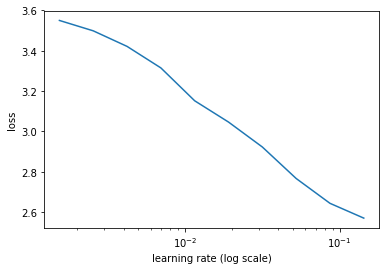

In [52]:
learn.sched.plot()

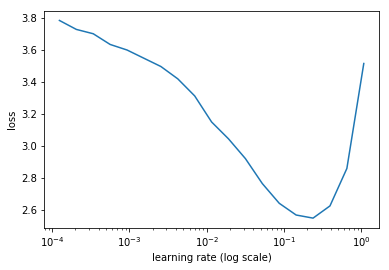

In [53]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [54]:
lr = 1e-1

In [55]:
learn.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      2.564073   1.077338   0.77479   



[1.0773375, 0.7747896611690521]

In [56]:
lrs = np.array([lr/1000, lr/100, lr])

In [57]:
learn

Sequential(
  (0): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-

In [58]:
learn.freeze_to(-2) # unfreeze last 2 layers

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 27/32 [00:18<00:03,  1.45it/s, loss=25.9]

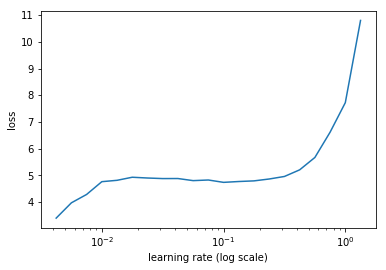

In [59]:
lr_f = learn.lr_find(lr/100)
learn.sched.plot(n_skip=5, n_skip_end=1)

In [60]:
learn.fit(lrs/10, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

  3%|▎         | 1/32 [00:01<00:44,  1.44s/it, loss=1.62]

Exception in thread Thread-9:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.620687   0.853778   0.822115  
    1      1.126093   0.761603   0.839093                 



[0.7616034, 0.8390925452113152]

In [61]:
learn.unfreeze()

In [62]:
learn.fit(lrs / 15, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.848761   0.703867   0.828425  
    1      0.632133   0.694889   0.832332                  



[0.6948895, 0.8323317319154739]

In [63]:
learn.save('class_one')
learn.load('class_one')

#### Accuracy isn't improving much - `since many images have multiple different objects`, it's going to be impossible to be that accurate.

## Let's check the results

In [64]:
x, y = next(iter(model_data.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x, preds = to_np(x), to_np(probs)
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


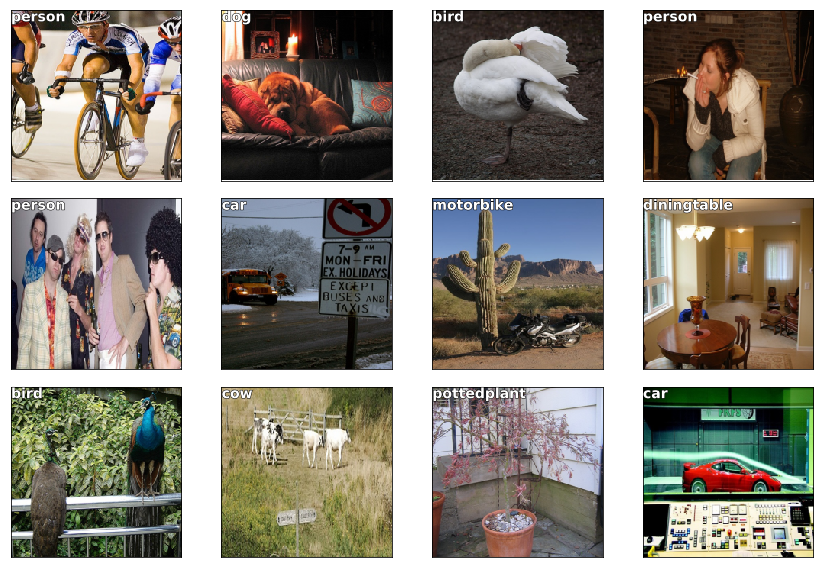

In [65]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ima = model_data.val_ds.denorm(x)[i]
    b =   model_data.classes[preds[i]]
    ax =  show_img(ima, ax=ax)
    draw_txt(ax, (0,0), b)
plt.tight_layout()

## Bounded box

In [66]:
BB_CSV = PATH/'tmp/bb.csv'

###### Now we'll try to find the bounding box of the largest object. This is simply a regression with 4 outputs. So we can use a CSV with multiple 'labels'.

In [67]:
trn_lrg_anno[23]

(array([  1,   2, 461, 242]), 15)

In [68]:
bb = np.array([trn_lrg_anno[id][0] for id in trn_ids])
bb_s = [' '.join(str(cord) for cord in cords) for cords in bb]

print(bb[0])
print(bb_s[0])

[ 96 155 269 350]
96 155 269 350


In [69]:
df = pd.DataFrame({'fn' : [trn_fnames[id] for id in trn_ids], 'bbox' : bb_s}, columns=['fn', 'bbox'])

In [70]:
df.head()

,fn,bbox
0,000012.jpg,96 155 269 350
1,000017.jpg,77 89 335 402
2,000023.jpg,1 2 461 242
3,000026.jpg,124 89 211 336
4,000032.jpg,77 103 182 374


In [71]:
df.to_csv(BB_CSV, index=False)

In [72]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

## Train

In [73]:
f_model = resnet34
sz = 224
bs = 64

Set `continuous=True` to tell fastai this is a **regression problem**, which means it **won't one-hot encode the labels**, and will use **MSE** as the default crit.

**Note** that we have to tell the transforms **constructor that our labels are coordinates**, so that it can handle the transforms correctly.

Also, we use **CropType.NO** because we want to 'squish' the rectangular images into squares, rather than center cropping, so that we don't accidentally crop out some of the objects. (This is less of an issue in something like imagenet, where there is a single object to classify, and it's generally large and centrally located).

In [74]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
model_data = ImageClassifierData.from_csv(PATH, JPEGS_PATH, BB_CSV, tfms=tfms, continuous=True)

In [75]:
x, y = next(iter(model_data.val_dl))

In [76]:
img = model_data.val_ds.denorm(to_np(x))[0]
b = bb_2_hw(to_np(y[0])); b

array([ 49.,   0., 131., 205.], dtype=float32)

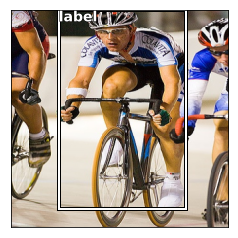

In [77]:
ax = show_img(img)
draw_rect(ax, b)
draw_txt(ax, b[:2], 'label')

### Custom layer

fastai let's you use a `custom_head` to add **your own module on top of a convnet**, _instead of the adaptive pooling and fully connected net which is added by default_. In this case, we **don't want to do any pooling, since we need to know the activations of each grid cell.**

The _final layer has 4 activations, one per bounding box coordinate._ Our **target is continuous**, not categorical, so the **MSE loss function used does not do any sigmoid or softmax** to the module outputs.

In [78]:
last_layer = nn.Sequential(Flatten(), nn.Linear(25088, 4))
learn = ConvLearner.pretrained(f_model, model_data, custom_head=last_layer)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [79]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 25/32 [00:07<00:02,  3.24it/s, loss=456] 


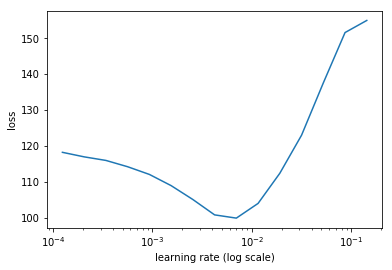

In [80]:
lrf = learn.lr_find(1e-5, 100)
learn.sched.plot(5)

In [81]:
lr = 2e-3

In [82]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      49.55249   35.541374 
    1      38.271908  28.832331                           
    2      31.809206  27.860249                           



[27.860249]

In [83]:
lrs = np.array([lr / 100, lr / 10, lr])

In [84]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      61.245032  10067336232960.0



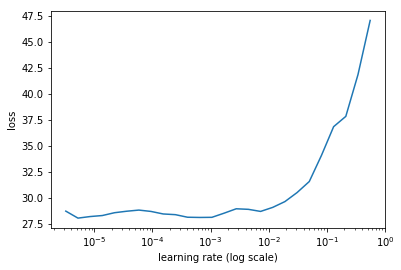

In [85]:
lrf = learn.lr_find(lrs / 1000)
learn.sched.plot(1)

In [86]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      25.926498  23.189114 
    1      22.271902  22.607599                           
    2      18.084075  20.637617                           



[20.637617]

In [87]:
learn.freeze_to(-3)

In [88]:
learn.fit(lrs, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      16.359476  21.76104  
    1      14.792944  20.254419                           



[20.25442]

In [89]:
learn.save('bb_4cords')

In [90]:
learn.load('bb_4cords')

#### Look at the results

In [91]:
x, y = next(iter(model_data.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


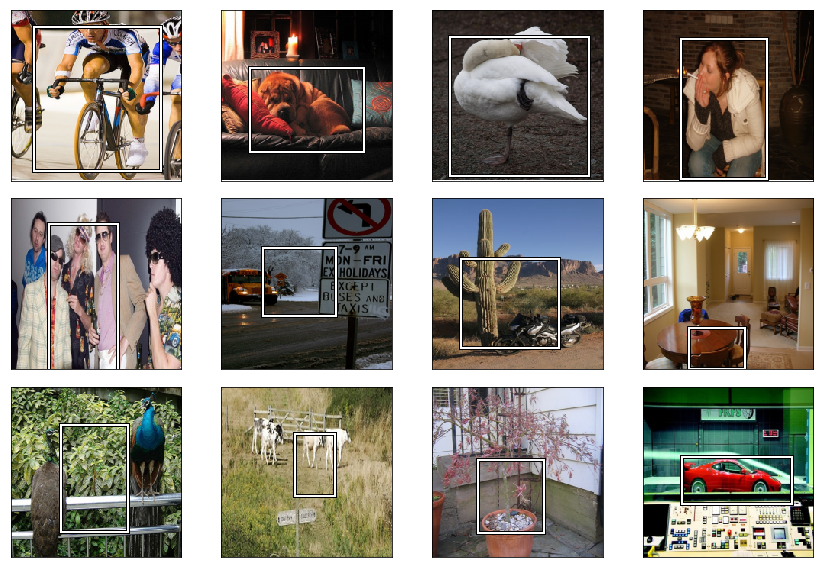

In [92]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=model_data.val_ds.denorm(to_np(x))[i]
    b = bb_2_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

# Single object detection

In [93]:
f_model = resnet34
sz = 224
bs = 64

In [94]:
val_idxs = get_cv_idxs(len(trn_fnames))

In [95]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
model_data = ImageClassifierData.from_csv(PATH, JPEGS_PATH, BB_CSV, tfms=tfms, continuous=True, val_idxs=val_idxs)

In [96]:
jpg_model_data = ImageClassifierData.from_csv(PATH, JPEGS_PATH, LRG_BB_CSV, tfms=tfms_from_model(f_model, sz))

###### A dataset can be anything with `__len__` and `__getitem__`. Here's a dataset that adds a 2nd label to an existing dataset:

In [97]:
class LabelDataset(Dataset):
    def __init__(self, ds, to_concat):
        self.ds = ds
        self.y2 = to_concat
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        return (x, (y, self.y2[i]))

###### Add classes to the bounding box labels

In [98]:
trn_ds2 = LabelDataset(model_data.trn_ds, jpg_model_data.trn_y)
val_ds2 = LabelDataset(model_data.val_ds, jpg_model_data.val_y)

In [99]:
val_ds2[0][1]

(array([  0.,  49., 205., 180.], dtype=float32), 14)

In [106]:
mx, my = next(iter(model_data.val_dl))
print(mx[0].size())
print(my[0].size())
my[0]

torch.Size([3, 224, 224])
torch.Size([4])



   0
  49
 205
 180
[torch.cuda.FloatTensor of size 4 (GPU 0)]

###### Replace the model dataloader's datasets with these

In [107]:
model_data.trn_dl.dataset = trn_ds2
model_data.val_dl.dataset = val_ds2

###### Denormalize the images for plotting

In [108]:
x, y = next(iter(model_data.val_dl))

img = model_data.val_ds.ds.denorm(to_np(x))[1]
b = bb_2_hw(to_np(y[0][1]))
b

array([  1.,  63., 222., 159.], dtype=float32)

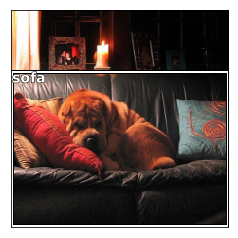

In [109]:
ax = show_img(img)

draw_rect(ax, b)
draw_txt(ax, b[:2], jpg_model_data.classes[y[1][1]])

In [114]:
cmx, cmy = next(iter(model_data.val_dl))
print(cmx[0].size())
print(cmy[0].size())
cmy

torch.Size([3, 224, 224])
torch.Size([64, 4])


[
     0    49   205   180
    63     1   222   223
    23    30   205   204
    38    52   222   158
    17   102   222   178
    92     0   142    74
   150    81   207   206
   159    19   222   123
     6   149   218   202
    53   136   108   169
     2     1   222   223
    95    53   138   181
   105   102   214   221
    22     6   217   196
    45    31   191   187
    53    15   213   221
    84   192   222   223
    49   116   213   196
    41    56   183   142
    16    72   144   165
    55    25   221   187
   106   173   185   207
    13     1   222   151
     1     7   221   222
    34    54   207   175
    34     9   166   202
    39   123   222   185
    69    26   144    69
   100    56   222   192
    26    38   159   199
    99    45   205   101
    65     5   136   219
    42    96   123   148
    54    37   183   190
    93    42   161   211
    48    32   174   147
    67     8   140    72
     0    11   127   170
    70   141   102   162
   131    24   217   19

##### We need one output activation for `each class (for its probability) `plus one for `each bounding box coordinate`. We'll use an `extra linear layer` this time, plus some `dropout`, to help us train a more flexible model.

In [115]:
last_layer = nn.Sequential(Flatten(), 
                           nn.ReLU(), 
                           nn.Dropout(0.5), 
                           nn.Linear(25088, 256), 
                           nn.ReLU(), 
                           nn.BatchNorm1d(256), 
                           nn.Dropout(0.5), 
                           nn.Linear(256, 4 + len(cats)))

In [116]:
model = ConvnetBuilder(f_model, 0, 0, 0, custom_head=last_layer)
learn = ConvLearner(model_data, model)
learn.opt_fn = optim.Adam

In [117]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t) * 20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

In [118]:
learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 97%|█████████▋| 31/32 [00:09<00:00,  3.31it/s, loss=807]


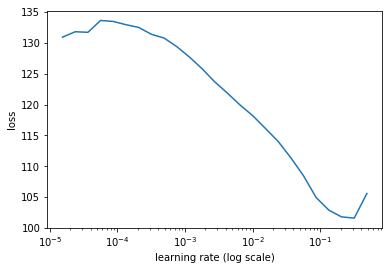

In [119]:
learn.lr_find()
learn.sched.plot(1)

In [120]:
lr = 1e-1

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      83.70281   81.412895  0.730469   44.262651 
    1      72.434007  53.23558   0.803486   38.800708     
    2      58.771544  42.149387  0.808444   29.848427     



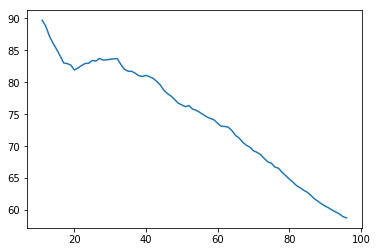

In [121]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32, 5))
learn.sched.plot_loss()

In [122]:
learn.save('reg1_0')

In [123]:
learn.freeze_to(-2)

In [124]:
lrs = np.array([lr/100, lr/10, lr])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 28/32 [00:19<00:02,  1.45it/s, loss=236] 

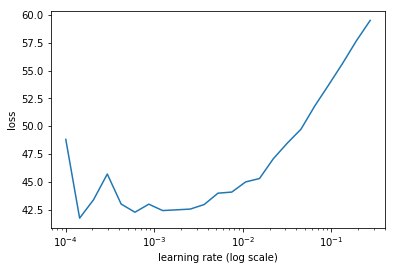

In [125]:
learn.lr_find(lrs / 1000)
learn.sched.plot(0)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  0%|          | 0/32 [00:00<?, ?it/s]                   


Exception in thread Thread-36:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      61.108684  105.004669 0.395132   36.575201 
    1      55.111689  55.358276  0.559345   26.786631     
    2      47.497775  52.327305  0.668269   25.371861     
    3      38.991818  43.660919  0.704778   22.79289      
    4      31.820562  43.066971  0.71244    22.44124      



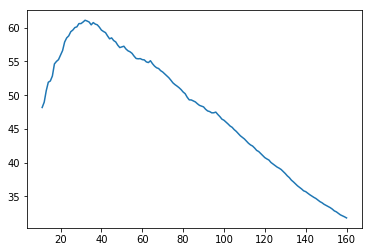

In [126]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32, 10))
learn.sched.plot_loss()

In [127]:
learn.save('reg1_1')

In [128]:
learn.load('reg1_1')

In [129]:
learn.unfreeze()

In [ ]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32, 10))
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      27.395745  66.13871   0.579477   25.503297 
    1      32.706253  53.435661  0.616587   24.381549     
    2      30.228447  51.584389  0.621394   23.172796     
    3      26.932066  50.921608  0.639423   24.281741     
    4      23.302399  48.933319  0.655048   22.340048     
    5      20.328176  47.955086  0.668269   22.7758       
    6      18.421417  47.853119  0.666316   22.136473     
    7      17.155454  46.741119  0.668269   22.152694     
 72%|███████▏  | 23/32 [00:21<00:08,  1.06it/s, loss=16.1]

In [ ]:
learn.save('reg1_2')

In [ ]:
learn.load('reg1_2')

## Check results

In [ ]:
y = learn.predict()
x, _ = next(iter(model_data.val_dl))

In [ ]:
from scipy.special import expit

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ima = model_data.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_2_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_txt(ax, b[:2], jpg_model_data.classes[c])
plt.tight_layout()